# **Capstone Project - The Battle of Neighborhoods**

## **1. Importing required Libraries**

In [1]:
import requests
import folium
import json
import xml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
from bs4 import BeautifulSoup

## **2. Scarping the data from Wikipedia**

Using Beautiful soup we extract the data from the Wikipedia Page

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
web_data = requests.get(url).text
soup = BeautifulSoup(web_data, "lxml")
table = soup.find("table")

Converting HTML data to Dataframe 

In [3]:
table_contents=[]
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)
data=pd.DataFrame(table_contents)
data['Borough']=data['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

Adding coordinates to the above dataframe

In [4]:
coordinates_data = pd.read_csv("/content/Geospatial_Coordinates.csv")
toronto_coordinates = pd.merge(data, coordinates_data, left_on="PostalCode", right_on="Postal Code")
toronto_coordinates.drop(columns=["Postal Code"], axis=1, inplace=True)
toronto_coordinates = toronto_coordinates[toronto_coordinates["Borough"] == "North York"]
toronto_coordinates

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
7,M3B,North York,Don Mills North,43.745906,-79.352188
10,M6B,North York,Glencairn,43.709577,-79.445073
13,M3C,North York,Don Mills South,43.725900,-79.340923
27,M2H,North York,Hillcrest Village,43.803762,-79.363452
28,M3H,North York,"Bathurst Manor, Wilson Heights, Downsview North",43.754328,-79.442259
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
34,M3J,North York,"Northwood Park, York University",43.767980,-79.487262


## **3. Map of NorthYork**

In [5]:
address = address = "North York, Toronto"
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of North York, Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of North York, Toronto are 43.7543263, -79.44911696639593.


In [6]:
map_northyork = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, borough, neighborhood in zip(toronto_coordinates.Latitude, toronto_coordinates.Longitude, toronto_coordinates.Borough, toronto_coordinates.Neighborhood):
  label = "{}, {}".format(neighborhood, borough)
  label = folium.Popup(label, parse_html=True)
  folium.CircleMarker([lat, lng], radius=10, color="blue", popup=label, fill=True, fill_color="red", fill_opacity=0.6).add_to(map_northyork)
map_northyork

Using Foursquare API Credentials to get data of nearby venues data

In [7]:
CLIENT_ID = "5BGRRQUUPOFG3NAJLCH2NHRG4E4RJAJHAWT5V4TAFSLAHNBN"
CLIENT_SECRET = "QYESNXMCCMEWWTXPHOC2CDUKJIWC1U0HSYCWCRX2Z1VO43UM"
ACCESS_TOKEN = "G5OECRZFCQBHPYXW2VDEHZDIK4VR0TWK5PWDWZLCAXZMTFZE"
VERSION = "20180604"
LIMIT = 30

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
north_york_venues = getNearbyVenues(toronto_coordinates.Neighborhood, toronto_coordinates.Latitude, toronto_coordinates.Longitude)

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills North
Glencairn
Don Mills South
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview East
York Mills, Silver Hills
Downsview West
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview Central
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale South
Downsview Northwest
York Mills West
Willowdale West


In [10]:
north_york_venues.groupby("Neighborhood").count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Bathurst Manor, Wilson Heights, Downsview North",3,3,3,3,3,3
"Bedford Park, Lawrence Manor East",4,4,4,4,4,4
Don Mills South,2,2,2,2,2,2
"Fairview, Henry Farm, Oriole",2,2,2,2,2,2
Glencairn,1,1,1,1,1,1
Hillcrest Village,1,1,1,1,1,1
"Lawrence Manor, Lawrence Heights",3,3,3,3,3,3


In [11]:
print("Thera are {} unique categories".format(len(north_york_venues["Venue Category"].unique())))

Thera are 12 unique categories


## **4. One Hot Encoding of features**

In [12]:
north_york_one_hot = pd.get_dummies(north_york_venues[["Venue Category"]], prefix="", prefix_sep="")
north_york_one_hot["Neighborhood"] = north_york_venues["Neighborhood"]
fixed_columns = [north_york_one_hot.columns[-1]] + list(north_york_one_hot.columns[:-1])
north_york_one_hot = north_york_one_hot[fixed_columns]
north_york_one_hot.head()

,Neighborhood,Bank,Boutique,Clothing Store,Coffee Shop,Deli / Bodega,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,Italian Restaurant,Restaurant,Sushi Restaurant,Theater
0,"Lawrence Manor, Lawrence Heights",0,1,0,0,0,0,0,0,0,0,0,0
1,"Lawrence Manor, Lawrence Heights",0,0,1,0,0,0,0,0,0,0,0,0
2,"Lawrence Manor, Lawrence Heights",0,0,1,0,0,0,0,0,0,0,0,0
3,Glencairn,0,0,0,0,0,0,0,0,1,0,0,0
4,Don Mills South,0,0,0,0,0,0,0,1,0,0,0,0


In [13]:
north_york_grouped = north_york_one_hot.groupby("Neighborhood").mean().reset_index()
north_york_grouped

,Neighborhood,Bank,Boutique,Clothing Store,Coffee Shop,Deli / Bodega,Fast Food Restaurant,Fried Chicken Joint,Grocery Store,Italian Restaurant,Restaurant,Sushi Restaurant,Theater
0,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.000000,0.333333,0.333333,0.00,0.333333,0.0,0.00,0.0,0.00,0.0
1,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.000000,0.250000,0.000000,0.25,0.000000,0.0,0.25,0.0,0.25,0.0
2,Don Mills South,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.5,0.00,0.5,0.00,0.0
3,"Fairview, Henry Farm, Oriole",0.5,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.00,0.5
4,Glencairn,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,1.00,0.0,0.00,0.0
5,Hillcrest Village,0.0,0.000000,0.000000,0.000000,0.000000,1.00,0.000000,0.0,0.00,0.0,0.00,0.0
6,"Lawrence Manor, Lawrence Heights",0.0,0.333333,0.666667,0.000000,0.000000,0.00,0.000000,0.0,0.00,0.0,0.00,0.0


In [14]:
top_venues_number = 10
for hood in north_york_grouped["Neighborhood"]:
  print("----------{}----------".format(hood))
  temp = north_york_grouped[north_york_grouped['Neighborhood'] == hood].T.reset_index()
  temp.columns = ['venue','freq']
  temp = temp.iloc[1:]
  temp['freq'] = temp['freq'].astype(float)
  temp = temp.round({'freq': 2})
  print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(top_venues_number))
  print('\n')

----------Bathurst Manor, Wilson Heights, Downsview North----------
                  venue  freq
0           Coffee Shop  0.33
1         Deli / Bodega  0.33
2   Fried Chicken Joint  0.33
3                  Bank  0.00
4              Boutique  0.00
5        Clothing Store  0.00
6  Fast Food Restaurant  0.00
7         Grocery Store  0.00
8    Italian Restaurant  0.00
9            Restaurant  0.00


----------Bedford Park, Lawrence Manor East----------
                  venue  freq
0           Coffee Shop  0.25
1  Fast Food Restaurant  0.25
2    Italian Restaurant  0.25
3      Sushi Restaurant  0.25
4                  Bank  0.00
5              Boutique  0.00
6        Clothing Store  0.00
7         Deli / Bodega  0.00
8   Fried Chicken Joint  0.00
9         Grocery Store  0.00


----------Don Mills South----------
                  venue  freq
0         Grocery Store   0.5
1            Restaurant   0.5
2                  Bank   0.0
3              Boutique   0.0
4        Clothing Store   0.

In [15]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = north_york_grouped['Neighborhood']

for ind in np.arange(north_york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(north_york_grouped.iloc[ind, :], top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Fried Chicken Joint,Deli / Bodega,Coffee Shop,Theater,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fast Food Restaurant,Clothing Store
1,"Bedford Park, Lawrence Manor East",Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Theater,Restaurant,Grocery Store,Fried Chicken Joint,Deli / Bodega,Clothing Store
2,Don Mills South,Restaurant,Grocery Store,Theater,Sushi Restaurant,Italian Restaurant,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop,Clothing Store
3,"Fairview, Henry Farm, Oriole",Theater,Bank,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop
4,Glencairn,Italian Restaurant,Theater,Sushi Restaurant,Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop,Clothing Store


## **5. K-Means Clustering**

In [17]:
north_york_grouped_clustering = north_york_grouped.drop("Neighborhood", 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(north_york_grouped_clustering)

In [18]:
neighborhoods_venues_sorted.insert(0, "Cluster labels", kmeans.labels_)
north_york_merged = toronto_coordinates
north_york_merged = north_york_merged.join(neighborhoods_venues_sorted.set_index("Neighborhood"), on="Neighborhood")
north_york_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M4A,North York,Victoria Village,43.725882,-79.315572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Boutique,Theater,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega
7,M3B,North York,Don Mills North,43.745906,-79.352188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,M6B,North York,Glencairn,43.709577,-79.445073,1.0,Italian Restaurant,Theater,Sushi Restaurant,Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop,Clothing Store


In [19]:
north_york_merged.dropna(inplace=True)

In [20]:
north_york_merged["Cluster labels"] = north_york_merged["Cluster labels"].astype("int")

In [21]:
import matplotlib.cm as cm
import matplotlib.colors as colors
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lon, poi, cluster in zip(north_york_merged['Latitude'], north_york_merged['Longitude'], north_york_merged['Neighborhood'], north_york_merged['Cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### **Cluster-1**

In [22]:
north_york_merged.loc[north_york_merged['Cluster labels'] == 0, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,0,Clothing Store,Boutique,Theater,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega
13,North York,0,Restaurant,Grocery Store,Theater,Sushi Restaurant,Italian Restaurant,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop,Clothing Store
28,North York,0,Fried Chicken Joint,Deli / Bodega,Coffee Shop,Theater,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fast Food Restaurant,Clothing Store
33,North York,0,Theater,Bank,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop
55,North York,0,Sushi Restaurant,Italian Restaurant,Fast Food Restaurant,Coffee Shop,Theater,Restaurant,Grocery Store,Fried Chicken Joint,Deli / Bodega,Clothing Store


### **Cluster-2**

In [23]:
north_york_merged.loc[north_york_merged['Cluster labels'] == 1, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,North York,1,Italian Restaurant,Theater,Sushi Restaurant,Restaurant,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Deli / Bodega,Coffee Shop,Clothing Store


### **Cluster-3**

In [24]:
north_york_merged.loc[north_york_merged['Cluster labels'] == 2, north_york_merged.columns[[1] + list(range(5, north_york_merged.shape[1]))]]

,Borough,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,North York,2,Fast Food Restaurant,Theater,Sushi Restaurant,Restaurant,Italian Restaurant,Grocery Store,Fried Chicken Joint,Deli / Bodega,Coffee Shop,Clothing Store


## **6. North York House Prices**

In [25]:
North_york_House_prices = pd.DataFrame({"Neighborhood" : toronto_coordinates["Neighborhood"], 
                                        "Prices" : [335000.0,286600.0,175000.0,225900.0,219400.0, 573900.0,
                                                    225000.0,370500.0,370500.0,433500.0,279200.0, 279200.0,
                                                    225000.0,370500.,255400.0,433500.0,433500.0,435000.0,289500.0,
                                                    265000.0,285900.0,239400.0,589900.0,295000.0 ]})
North_york_House_prices

,Neighborhood,Prices
0,Parkwoods,335000.0
1,Victoria Village,286600.0
3,"Lawrence Manor, Lawrence Heights",175000.0
7,Don Mills North,225900.0
10,Glencairn,219400.0
13,Don Mills South,573900.0
27,Hillcrest Village,225000.0
28,"Bathurst Manor, Wilson Heights, Downsview North",370500.0
33,"Fairview, Henry Farm, Oriole",370500.0
34,"Northwood Park, York University",433500.0


Plotting the bar graph of Neighborhood v/s Houseprice 

Text(0.5, 1.0, 'Neighborhood v/s Houseprices in North york')

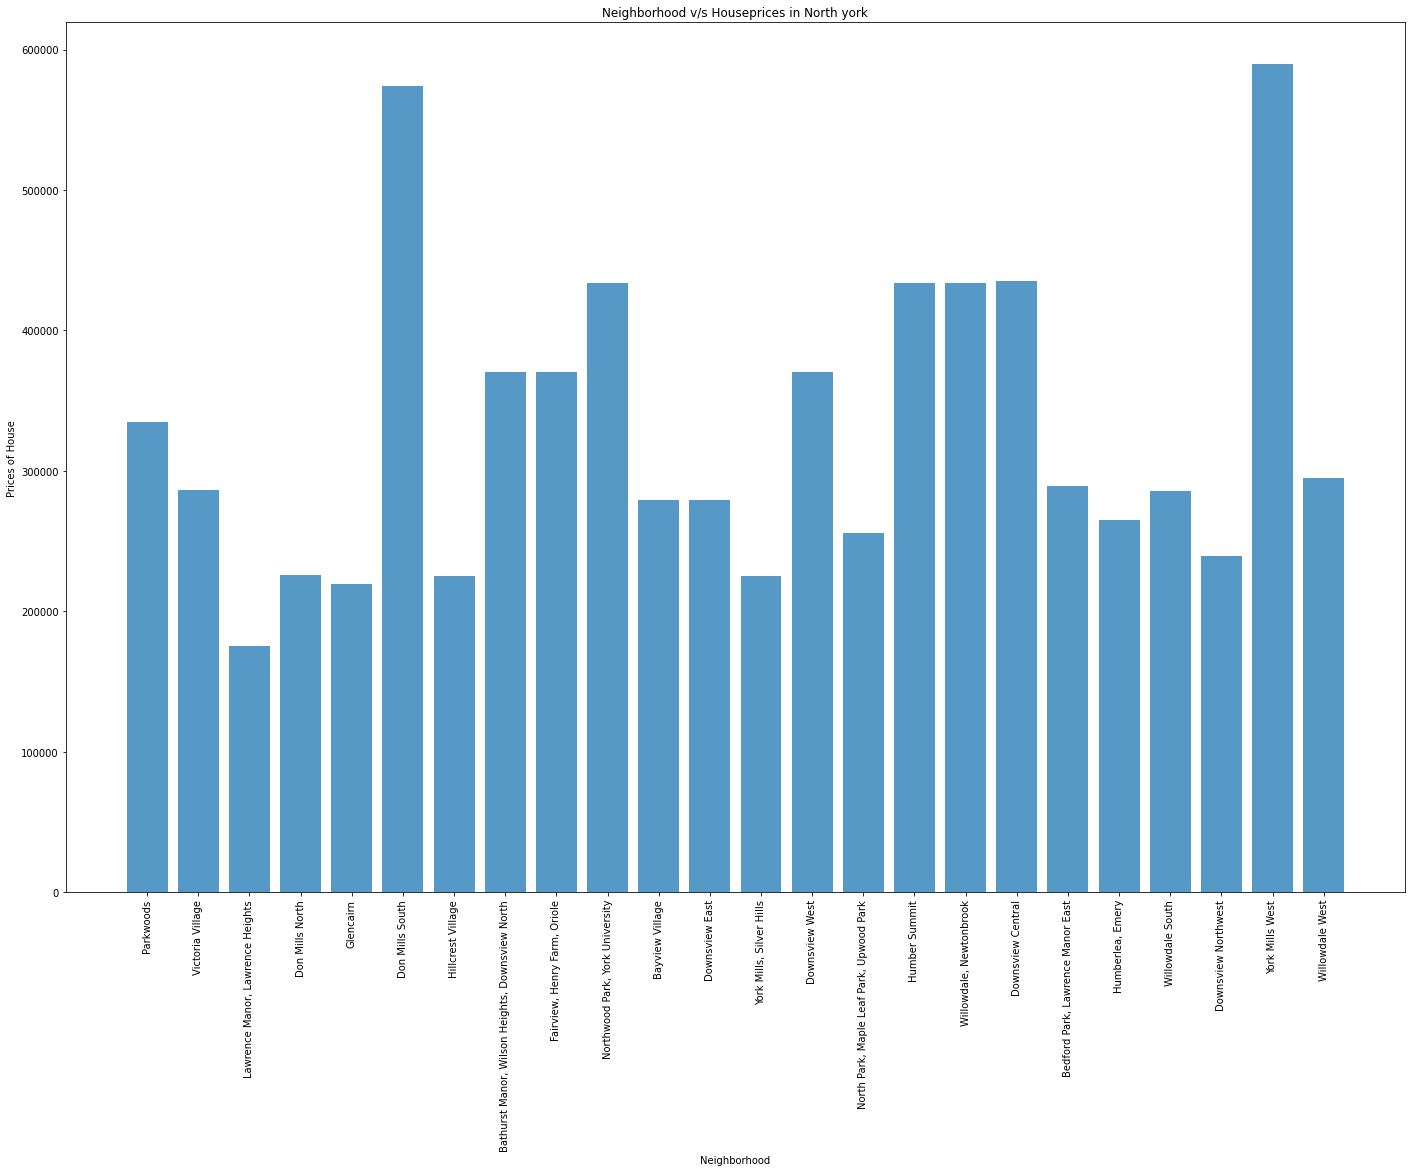

In [26]:
plt.figure(figsize=(24,16))
plt.bar(North_york_House_prices["Neighborhood"], North_york_House_prices["Prices"], alpha=0.75)
plt.xticks(rotation="vertical")
plt.xlabel("Neighborhood")
plt.ylabel("Prices of House")
plt.title("Neighborhood v/s Houseprices in North york")

## **7. NorthYork School Ratings**

In [27]:
North_york_school_ratings = pd.DataFrame({"Neighborhood" : toronto_coordinates["Neighborhood"], 
                                        "Ratings" : [7,9,5,8,10,10,7,10,2,1,2,7,2,3,2,6,8,6,6,8,10,8,9,6]})

Plotting the bar graph of Neighborhood v/s School ratings

Text(0.5, 1.0, 'Neighborhood v/s School ratings in North york')

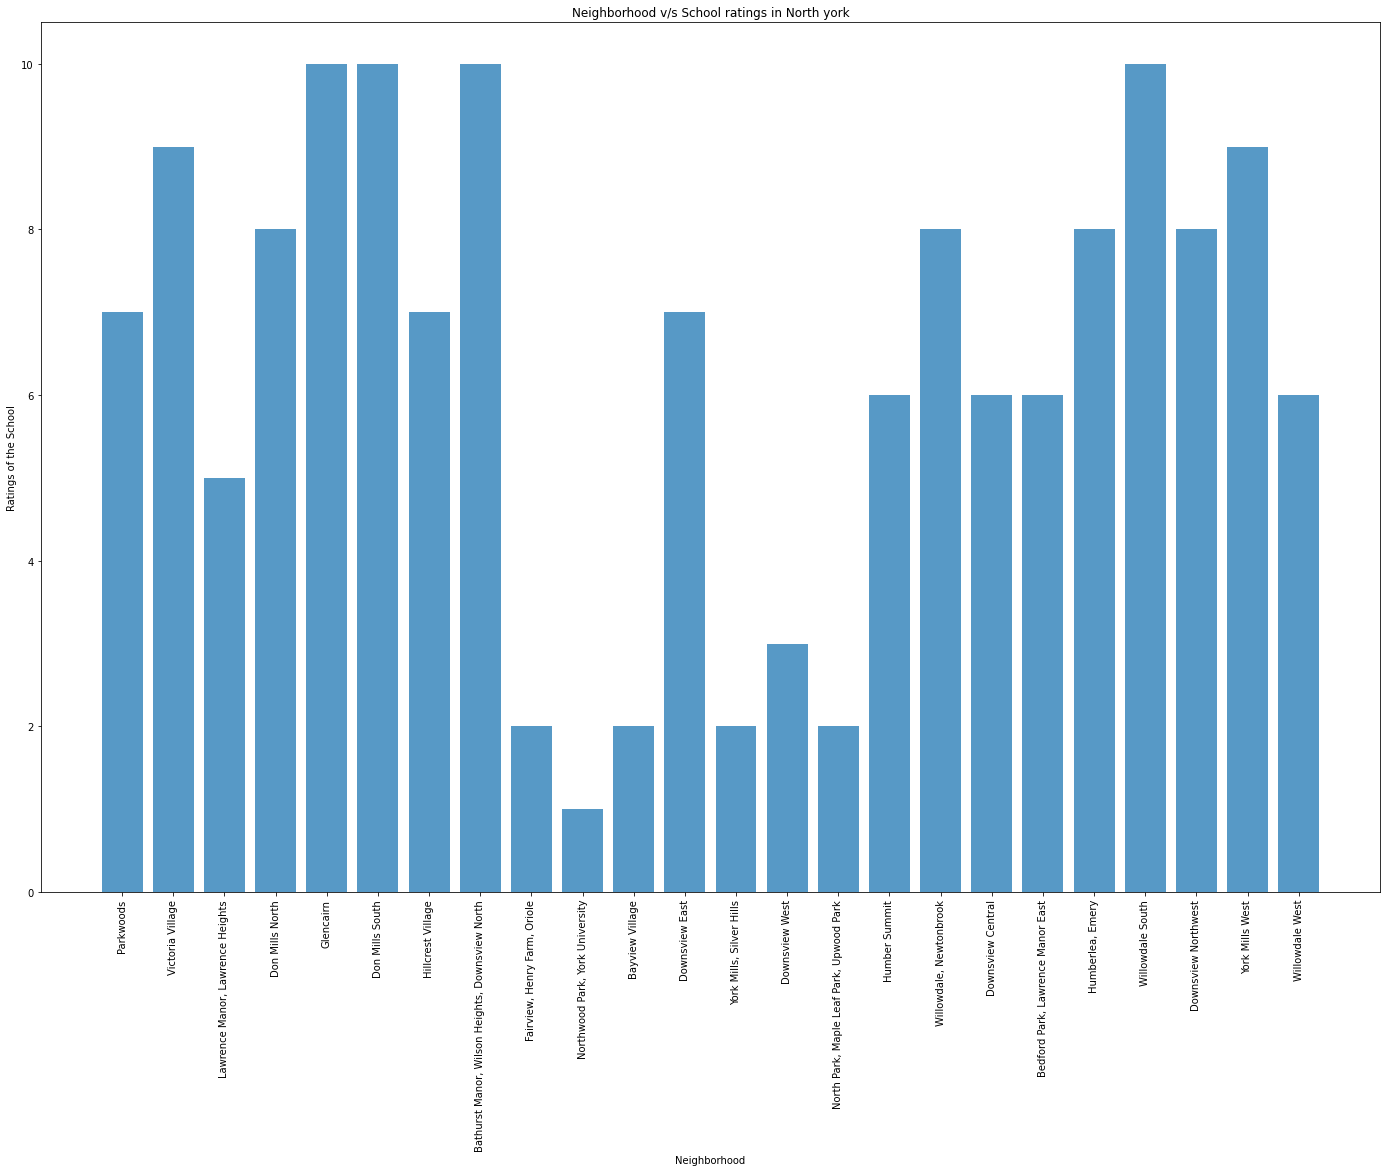

In [28]:
plt.figure(figsize=(24,16))
plt.bar(North_york_school_ratings["Neighborhood"], North_york_school_ratings["Ratings"], alpha=0.75)
plt.xticks(rotation="vertical")
plt.xlabel("Neighborhood")
plt.ylabel("Ratings of the School")
plt.title("Neighborhood v/s School ratings in North york")